# WARS: Wes Anderson Recommendation System

By Jacob Klein and Omar Pardo Gomez (Columbia University)

## Business Problem

We are _Best Film Recommenders (BFR)_, a company located in NYC and founded by two Columbia Students in 2014. Since our inception, we have been recognized by our users for our accurate and personalized movie recommendations. However, our industry is always evolving, requiring constant improvements to remain competitive and profitable.

A week ago we received a letter from _Wes Anderson Productions (WAP)_, the company which owns the rights for every movie directed by Wes Anderson. Within the letter they claim that despite the high quality of Wes Anderson's films, most of his work is still unknown by most consumers. The only exceptions are _The Grand Budapest Hotel (2014)_ (which received critical acclaim, including nine Oscars nominations), and _Isle of Dogs (2018)_, which popularity was boosted by the former's success.

Due to WAP films having high ratings yet low viewership, the company believes that six of Wes Anderson's films are unpopular due to a lack of publicity when they were released. With the Christmas season approaching, WAP believe that target advertising can bring in new viewers that never knew the movies existed, increasing revenue from movie sales. For this reason, WAP are willing to pay a significant sum of money if we can reach more users, representing a significant potential income for our company.

While we could recommend the six movies to all our customers, our company's mission has always been focussed on our users, and we don't want to make recommendations they can find irrelevant. Because of this, we would like to find the movie which is most likely to be enjoyed by each user among the following films: 

* _Rushmore (1998)_
* _The Royal Tenenbaums (2001)_
* _The Life Aquatic with Steve Zissou (2004)_
* _The Darjeeling Limited (2007)_
* _Fantastic Mr. Fox (2009)_
* _Moonrise Kingdom (2012)_

Therefore, our goal will be to build a new _Wes Anderson Recommendation System (WARS)_, to find the ideal movie per user. While we have no _accuracy cutoff_, we want our recommendations to be as targeted as possible to keep a high availability of advertising space, should new clients wish to use our services.

## Data Overview

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import collections

Similar to our previous recommendation systems, we are going to use subsets of the full data set for education and development from [MovieLens](https://grouplens.org/datasets/movielens/). For now let's focus on the main table: The `ratings` table contains the **rating** that a **user** gave to one **movie**, as well as the moment in **time** when this happened.

In [2]:
df_ratings = pd.read_csv('movie_data/ratings.csv')
df_ratings.head(5)

,userId,movieId,rating,timestamp
0,1,307,3.5,1256677221
1,1,481,3.5,1256677456
2,1,1091,1.5,1256677471
3,1,1257,4.5,1256677460
4,1,1449,4.5,1256677264


From previous experience we know that people can change their preferences and opinions over time. Therefore, to ensure the quality of our data, we will use only ratings given since 2016.

In [3]:
def get_year(ts):
    return datetime.fromtimestamp(int(ts)).year

df_ratings['year'] = df_ratings['timestamp'].apply(get_year)
min_year = 2016
df_ratings = df_ratings[df_ratings.year >= min_year][['userId', 'movieId', 'rating']]

Before we start, let's confirm or deny the _WAP_'s hypothesis: Are the six proposed movies truly unpopular, but good?

To do that, let's count the number of total opinions, and the average rating of all the movies in the dataset, and then compare them with the _WAP_ movies.

In [4]:
df_movies = df_ratings.groupby(['movieId']).agg({'rating':['count', np.mean]}).rating
wap_movies = np.array([2395, 4979, 30810, 55269, 72226, 94959])

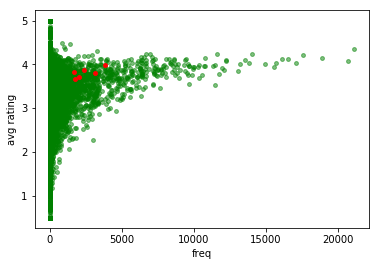

In [5]:
x = df_movies['count']
y = df_movies['mean']
x_wap = df_movies[df_movies.index.isin(wap_movies)]['count']
y_wap = df_movies[df_movies.index.isin(wap_movies)]['mean']

plt.scatter(x, y, c="green", alpha=0.5, s=15)
plt.scatter(x_wap, y_wap, c="red", s=15)
plt.xlabel("freq")
plt.ylabel("avg rating")
plt.show()

Watching the red points (_WAP_ movies), they are up to the left. In other words, the six proposed movies seem to be unpopular, but good, confirming the hypothesis.

## Previous Approaches

Since we had never faced a similar problem before, and to maximize the breadth of our training, we designed datasets with different characteristics, tried multiple kinds of recommendation techniques, and fitted the models by shifting several hyperparameters. All with the intention to find what worked and what didn't for the beta version of _WARS_.

### Datasets

Our first idea for the model dataset was to use as items **only the six WAP proposed movies**. However, we thought that working with only six items could be insufficient for a recommendation system. Then, we decided to add other **unpopular-but-good** movies, which we called **target movies**. To be more specific, we defined a target movie as one with between **1500 and 4000 opinions** since 2016, and an **average rating greater or equal than 3.6**. This kind of movies are shown as a rectangle in the next plot.

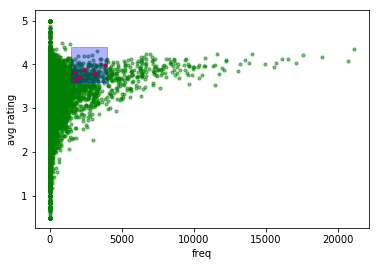

In [6]:
from matplotlib.patches import Rectangle
plt.scatter(x, y, c="green", alpha=0.5, s=10)
plt.scatter(x_wap, y_wap, c="red", s=10)
ax = plt.gca()
ax.add_patch(Rectangle((1500, 3.6), 2500, 0.8, color='b', alpha=0.3))
plt.xlabel("freq")
plt.ylabel("avg rating")
plt.show()

Finally, we built a third dataset that included films **at least as popular** as the previous ones (more than 1500 opinions since 2016), but which were **not considered target**, either because they had more than 4000 opinions, or because their average rating was lower than 3.6.

### Recommendation Techniques

All the recommendation techiniques we used for the previous approach belonged to the **collaborative filtering** methods. That means they all use nothing but the ratings the different users gave to the movies in the *MovieLens* catalog. We tried with **neighborhood-based techniques** (focusing on **items**, because that is the nature of this problem), particularly several kinds of *k-NN* methods (basic, with means, with z-score). Also, we used **model-based** techniques, particularly matrix factorization methods as SVD and SVD++. To fit all these recommendation algorithms we tried different hyperparameters thanks to the Python `suprise` library, which turned out to be very useful for that initial approach.

### Insights

The two main insights we got from that previous approach were the following:

- After training models with the three previously described datasets, even when we calculated the accuracy metrics just for the WAP movies, the **best performance** was obtained when we included **all the movies** (wap movies, target movies and non-target movies). Our hypothesis is that the more data you give it, the better the algorithm behaves. That is in general, and in particular, for the Wes Anderson films' ratings predictions.

- The SVD++ got the **best accuracy** among the collaborative filtering techniques. That suggests that the **matrix factorization techniques** can work well for this problem.

## New Approach: Factorization Machines

**Factorization Machines (FMs)** are a novel technique, and a **state of the art solution** within the Recommendation Systems context. This technique allows the algorithm to **add information different from the *user-movie* ratings** and is similar to the matrix factorization techniques in the sense that also **works with latent vectors** to generate interactions. Therefore, it seems like the **ideal algorithm** to explore so that we can improve what we already done using the collaborative filtering approach.

### Implicit Feedback

One critical thing to take into consideration is that the mission WAP gave us is to find the people who are more likely to watch their movies and that goal not necessarily means to find the users that would like them the most. In other words, we are **not facing the classic explicit feedback problem** (when we want to predict the ratings), **but an implicit one** (we want to predict who will watch it or not).

It sounds like now we are facing a classification-related problem, with a binary answer: will watch the movie (1) or won't watch the movie (0). To train the model, we will assume that **if a user has already rated a movie**, is because she/he has already watched it. Then, those are going to be **our 1's**. On the other side, all the movies a given user **hasn't rated** will be counted as **0's**.

In consequence, we need **new metrics to measure our model's performance**, and which will be related to the ones commonly used in the classification context. We will use the traditional [AUC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_the_curve) as our main accuracy metric, since it joins in one metric the tradeoff between *precision* and *recall*. However, we will also measure one modified version of both called *precision at k* and *recall at k*, to watch the effects of different changes on our train/test datasets.

**Precision at k** is defined as the percentage of movies an user has actually watched, of his/her k-highest positive predictions. On the other side, **recall at k** is the percentage of movies that are in the his/her first k-positive predictions, from all the movies the he/she has already watched. The intention of using this new metrics is because we normally **recommend the most likely k-movies** to be watched by a user, and we **don't care about the order of all the others**. Since we normally **show 5 recommendations** to our users, we will set **k=5** for all the subsequent tests.

Fortunately, all what we have just described is already implemented in the Python library [LightFM](https://github.com/lyst/lightfm), which is the one we will use for the next exercises.

### Baseline Model 

To start exploring this approach, we will build a dataset that contains 300 total movies: 6 of them will be the *WAP* movies, and 294 will be randomly chosen from all the movies that are at least as popular (1500 ratings since 2106) as Wes Anderson's least popular movie. 

In [7]:
np.random.seed(2018)
df_reviews = df_ratings.groupby(['movieId']).userId.count().reset_index()
reviewed_movies = np.setdiff1d(df_reviews[df_reviews['userId'] >= 1500].index, wap_movies)
sampled_movies = np.random.choice(reviewed_movies, size=294, replace=False)
selected_movies = np.concatenate((wap_movies, sampled_movies))

Also, we will sample 3000 users who have rated at least one of the selected movies. 

In [8]:
df_ratings_sample1 = df_ratings[df_ratings.movieId.isin(selected_movies)]
users = np.unique(df_ratings_sample1.userId)
sampled_users = np.random.choice(users, size=3000, replace=False)
df_ratings_sample = df_ratings_sample1[df_ratings_sample1.userId.isin(sampled_users)]
df_ratings_sample.head(5)

,userId,movieId,rating
2401,36,2324,4.0
2403,36,2395,4.0
2416,36,4027,4.5
2426,36,4979,4.0
2445,36,30810,4.0


Around 27% of the ratings on this dataset are for Wes Anderson movies.

In [9]:
round(df_ratings_sample[df_ratings_sample.movieId.isin(wap_movies)].shape[0] / df_ratings_sample.shape[0], 2)

0.27

Therefore, we will take 50% from the Wes Anderson's ratings to constitute the `test` dataset, and the other 50% is going to be part of the `train` dataset, as well as the other films. On this way, the `test` dataset will represent around 14% from the total sample.

In [10]:
df_wap_ratings = df_ratings_sample[df_ratings_sample.movieId.isin(wap_movies)]
df_test_sample = df_wap_ratings.sample(frac = 0.50)
df_train_sample = pd.concat([df_ratings_sample, df_test_sample]).drop_duplicates(keep=False)

Now, we import the necessary functions to fit the Factorization Machines algorithm. We will do this so that this report remains clear.

In [11]:
from fms import *

/anaconda3/lib/python3.7/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn('LightFM was compiled without OpenMP support. '


Is time to fit our **Baseline** model, which is actually just a **collaborative filtering matrix factorization**, since we **haven't added additional information**.

In [12]:
baseline_performance = get_dataset_performance(
    df_ratings_sample,
    df_train_sample,
    df_test_sample
)

Model
Precision at k=5: 0.108
Recall at k=5: 0.345
AUC: 0.938


### Features

Now, we will try to improve this metrics adding additional information. To do that we will import the other data given by MovieLens, which we will describe on the next lines.

In [13]:
df_movies = pd.read_csv('movie_data/movies.csv')
df_tags = pd.read_csv('movie_data/tags.csv')
df_genome_scores = pd.read_csv('movie_data/genome-scores.csv')
df_genome_tags = pd.read_csv('movie_data/genome-tags.csv')
df_genome = pd.merge(df_genome_scores, df_genome_tags, on='tagId', how='inner')

We will also import the necessary functions to transform everything to the format LightFM needs to work.

In [14]:
from features import *

We will create some dictionaries, so that every every feature is uniquely associated with one index.

The first dictionary is the one for the **genres**. This information will be translated to the features on the next way:
- **User**: The percentage of the movies the user rated that belong to that genre. For instance, if the user rated two movies, one which was a Drama/Action, and another that was only Drama, the Drama column will show 1.0, the Action column 0.5, and all the others 0.0
- **Movie**: The genres that are present in one movie, weighted by the number of them. For example, if one movie is Horror/Crime/Adventure, each of those columns will present 0.33, and all the others 0.0. However, if one film is just Sci-Fi, that column will show a 1.0, and 0.0 for the rest.

The second dictionary is the one for the **popular tags**. This data will be translated **only to the user's features** on the following way: We will take the n-most popular tags, and whenever one costumer uses one of them, we will give it a 1 divided by the number of tags the user has given. For example, if the user uses *based on a book* (which is one of the popular ones) two times, and *I slept and don't remember* (which is unpopular), the *based on a book* column will present 0.66, and all the other popular, 0.0.

Finally, the third dictionary is for the **relevant tags**. MovieLens has a machine learning algorithm which infers the **relevance of each tag to describe the movie**. We will choose the k-most relevant tags, in terms of their average relevance. Then, we will assign the relevance score to the corresponding columns for each tag (the score is between 0 and 1 and has a value for every movie-tag combination).

In [15]:
genres_dict = get_genres_dict(df_movies)
number = 50
pop_tags_dict = get_popular_tags_dict(df_tags, number)
rel_tags_dict = get_relevant_tags_dict(df_genome, number)

Now we get the features for every user and item in our dataset.

In [16]:
user_features_all_train = get_user_all_features(df_train_sample, df_movies, df_tags, genres_dict, pop_tags_dict)
user_features_all_test = get_user_all_features(df_test_sample, df_movies, df_tags, genres_dict, pop_tags_dict)
movie_features_all_train = get_movie_all_features(df_train_sample, df_movies, df_genome, genres_dict, rel_tags_dict)
movie_features_all_test = get_movie_all_features(df_test_sample, df_movies, df_genome, genres_dict, rel_tags_dict)

We will start just adding for every user the **percentage of the 300 movies** that has already rated, and for every movie the **percentage of the 3000 users** that have already rated the film.

In [17]:
user_features_train = user_features_all_train['features_m']
user_features_test = user_features_all_test['features_m']
movie_features_train = movie_features_all_train['features_u']
movie_features_test = movie_features_all_test['features_u']

get_dataset_performance(
    df_ratings_sample,
    df_train_sample,
    df_test_sample,
    user_features_train,
    movie_features_train,
    user_features_test,
    movie_features_test
)

Model
Precision at k=5: 0.22
Recall at k=5: 0.702
AUC: 0.969


{'precision': 0.22, 'recall': 0.702, 'auc': 0.969}

Even with this little additional information, we can see that the model is already showing an improvement. Now, we will add the **genre** information for both, the users and the movies.

In [18]:
user_features_train = user_features_all_train['features_mg']
user_features_test = user_features_all_test['features_mg']
movie_features_train = movie_features_all_train['features_ug']
movie_features_test = movie_features_all_test['features_ug']

get_dataset_performance(
    df_ratings_sample,
    df_train_sample,
    df_test_sample,
    user_features_train,
    movie_features_train,
    user_features_test,
    movie_features_test
)

Model
Precision at k=5: 0.234
Recall at k=5: 0.799
AUC: 0.979


{'precision': 0.234, 'recall': 0.799, 'auc': 0.979}

In this ocassion, we got similar results than when we just gave the algorithm the percentage of movies/users. Now, let's see what happens when we add the **tags data** (popular tags for users and relevant tags for movies).

In [19]:
user_features_train = user_features_all_train['features_mgt']
user_features_test = user_features_all_test['features_mgt']
movie_features_train = movie_features_all_train['features_ugt']
movie_features_test = movie_features_all_test['features_ugt']

get_dataset_performance(
    df_ratings_sample,
    df_train_sample,
    df_test_sample,
    user_features_train,
    movie_features_train,
    user_features_test,
    movie_features_test
)

Model
Precision at k=5: 0.001
Recall at k=5: 0.002
AUC: 0.847


{'precision': 0.001, 'recall': 0.002, 'auc': 0.847}

As we can see, it seems like this information only **confused the algorithm**! The results are clearly worse than the previous models, and even that the Baseline. Let's note that more information not necessarily translates into a better performance.

#### Tuning parameters

Now, to further refine our FM modelling tenchnique we are going to test our baseline along with varied user/movie features while also changing the sampling size of users and items. We will also explore whether dense matrices perform better.

In [20]:
import time
from param_tune import *

In [21]:
%%capture
precision = []
recall = []
auc = []
runtime = []
sample_sizes = [200,250,300,350,400,450,500,550,600,650]

for movie_size in sample_sizes:
    res = tune_basic(movie_size, 2000, df_ratings, wap_movies);
    
    precision.append(res['precision'])
    recall.append(res['recall'])
    auc.append(res['auc'])
    runtime.append(res['time'])

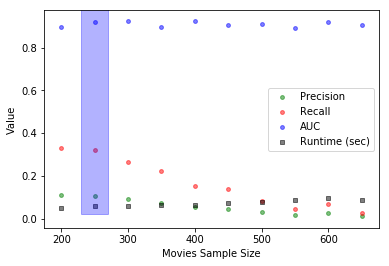

In [22]:
plt.scatter(sample_sizes, precision, c="green", alpha=0.5, s=15, label="Precision")
plt.scatter(sample_sizes, recall, c="red", alpha=0.5, s=15, label="Recall")
plt.scatter(sample_sizes, auc, c="blue", alpha=0.5, s=15, label="AUC")
plt.scatter(sample_sizes, runtime, c="black", marker='s', alpha=0.5, s=15, label="Runtime (sec)")
ax = plt.gca()
ax.add_patch(Rectangle((230, 0.02), 40, 0.96, color='b', alpha=0.3))
plt.xlabel("Movies Sample Size")
plt.ylabel("Value")
plt.legend()
plt.show()

As shown above, a **larger sample size does not neccesairily lead to an increase in AUC for the model**. Also, by adding more movies the training time increases, and precision/recall both decrease. After analyzing the chart above the group will be **using 250 movies** for the remainder of the report as that is what appears to maximize the balance of AUC, Recall and Precision all while balancing runtime.

In [23]:
%%capture
precision = []
recall = []
auc = []
runtime = []
user_sizes = [1000,2000,3000,4000,5000,6000,7000,8000,9000,10000]

for user_size in user_sizes:
    res = tune_basic(250, user_size, df_ratings, wap_movies);
    
    precision.append(res['precision'])
    recall.append(res['recall'])
    auc.append(res['auc'])
    runtime.append(res['time'])

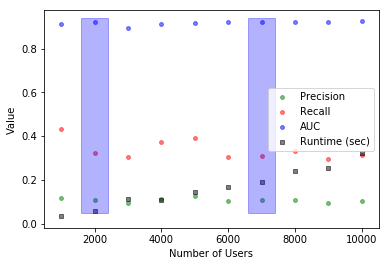

In [24]:
plt.scatter(user_sizes, precision, c="green", alpha=0.5, s=15, label="Precision")
plt.scatter(user_sizes, recall, c="red", alpha=0.5, s=15, label="Recall")
plt.scatter(user_sizes, auc, c="blue", alpha=0.5, s=15, label="AUC")
plt.scatter(user_sizes, runtime, c="black", marker='s', alpha=0.5, s=15, label="Runtime (sec)")
ax = plt.gca()
ax.add_patch(Rectangle((1600, 0.05), 800, 0.89, color='b', alpha=0.3))
ax.add_patch(Rectangle((6600, 0.05), 800, 0.89, color='b', alpha=0.3))
plt.xlabel("Number of Users")
plt.ylabel("Value")
plt.legend()
plt.show()

As shown above the models results follow a **cyclical pattern** as additional users are added to the model's training set. It is also evident that there is a **local maximum for the AUC at 2000 users**. Therefore, future models will be limited to a **sample of 2000 users**. This can be explained as adding **additional users that have not rated a large number of movies will lead to more overall information but weaker relationships between items and users**. Another reason to select 2000 over say 7000 is that the AUC gain is so minimal compared to the runtime increase that it is not worth the added complexity.

In [25]:
%%capture
precision = []
recall = []
auc = []
runtime = []
tag_sizes = [50,100,150,200,250,300,350,400]

for tag_size in tag_sizes:
    res = tune_features(tag_size, df_ratings, wap_movies, df_movies, df_tags, df_genome, pop_tags_dict, rel_tags_dict);

    precision.append(res['precision'])
    recall.append(res['recall'])
    auc.append(res['auc'])
    runtime.append(res['time'])

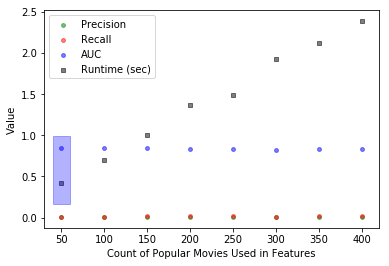

In [26]:
plt.scatter(tag_sizes, precision, c="green", alpha=0.5, s=15, label="Precision")
plt.scatter(tag_sizes, recall, c="red", alpha=0.5, s=15, label="Recall")
plt.scatter(tag_sizes, auc, c="blue", alpha=0.5, s=15, label="AUC")
plt.scatter(tag_sizes, runtime, c="black", marker='s', alpha=0.5, s=15, label="Runtime (sec)")
ax = plt.gca()
ax.add_patch(Rectangle((40, 0.17), 20, 0.82, color='b', alpha=0.3))
plt.xlabel("Count of Popular Movies Used in Features")
plt.ylabel("Value")
plt.legend()
plt.show()

As shown above including additional user or item information relating to tag or relevance only worsens all the accuracy metrics of our model. For this reason, these won't be included in the user and item features of our final model.

## Results on WAP problem

Now that we have found the parameters and features that should be used based on accuracy gains weighted against computational complexity one must compare the final model to all the preliminary models to determine how the model has improved and what its current performance will be.

In [28]:
%%capture
precision = []
recall = []
auc = []
runtime = []
names = ['baseline', 'fixed subsetting', 'fixed features & num tags']

res = tune_basic(300, 3000, df_ratings, wap_movies); 
precision.append(res['precision'])
recall.append(res['recall'])
auc.append(res['auc'])
runtime.append(res['time'])

res = tune_basic(250, 2000, df_ratings, wap_movies); 
precision.append(res['precision'])
recall.append(res['recall'])
auc.append(res['auc'])
runtime.append(res['time'])

res = tune_features(50, df_ratings, wap_movies, df_movies, df_tags, df_genome, pop_tags_dict, rel_tags_dict, 'ug');
precision.append(res['precision'])
recall.append(res['recall'])
auc.append(res['auc'])
runtime.append(res['time'])

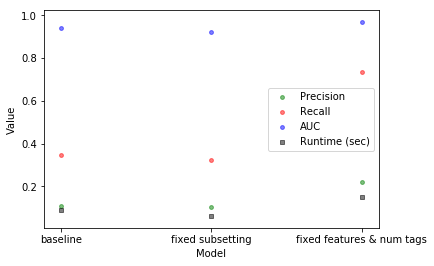

			Baseline (fixed dims)	Baseline (optimized dims)	Added/tweaked features	
Precision:			0.108			0.106			0.222
Recall:				0.345			0.322			0.735
AUC:				0.938			0.922			0.97
Time (sec):			0.09			0.062			0.152


In [29]:
plt.scatter(names, precision, c="green", alpha=0.5, s=15, label="Precision")
plt.scatter(names, recall, c="red", alpha=0.5, s=15, label="Recall")
plt.scatter(names, auc, c="blue", alpha=0.5, s=15, label="AUC")
plt.scatter(names, runtime, c="black", marker='s', alpha=0.5, s=15, label="Runtime (sec)")
ax = plt.gca()
plt.xlabel("Model")
plt.ylabel("Value")
plt.legend()
plt.show()

print('\033[1m','\t\tBaseline (fixed dims)','Baseline (optimized dims)','Added/tweaked features','\033[0m', sep='\t')
print('Precision:', precision[0], precision[1], precision[2], sep='\t\t\t')
print('Recall:\t', recall[0], recall[1], recall[2], sep='\t\t\t')
print('AUC:\t', auc[0], auc[1], auc[2], sep='\t\t\t')
print('Time (sec):', round(runtime[0],3), round(runtime[1],3), round(runtime[2],3), sep='\t\t\t')

## Conclusion

As shown in the results section, the **model's final performance was signficantly greater than any individual model previously created**. This shows that our **parameter choices** along with the **addition of user and movie features** successfully **increased the overall performance** of the model while still **maintaining speed**. 

Before this model is placed into production a few shortcomings or key decisions should be adressed.
- Firstly, this **solution focussed on precision over recall**: if a user is shown an advertisement and does not end up watching the movie we view this far more negatively than an individual who is interested in a movie but never ends up seeing an ad. By erring on the side of caution when making predictions one can provide positive advertising experiences to the user at the sacrifice of lost revenue due to missed opportunities.
- Secondly, the **computational requirements of the model should be solidifed**. In this phase the team selected 2000 as the max users for training/evaluation. This selection performed slightly worse than 7000 users but was multiple times faster while only sacrificing minimal accuracy. Should the model be too inaccurate for production, some of the parameters can be modified to increase accuracy at the cost of runtime.

While the group is content with their progress there are three stretch goals that they would have liked to complete:

**1.** Work on creating **additional user and movie features** to be included in the FM models. Potentially look at external resources such as wikipedia of IMDB for additional movie features.

**2.** They would have liked to explore LightFM's **fit_partial functionalilty to retrain the model** periodically based on emulated streaming data (mimicing a production environment). 

**3.** The group would have liked to implement **Neural Factorization Machines (NFMs)** as outlined in [this paper](https://arxiv.org/pdf/1708.05027.pdf). We believe that the sparse feature matrices we extracted from the MovieLens dataset would have worked well with the approach utilized within the paper.